# Context

Every day, the introduction of data science into the field of law and justice is becoming more common. A well-known example of this is the COMPAS system (Correctional Offender Management Profiling for Alternative Sanctions), which is used in several states in the United States to assess the risk of recidivism for detained individuals. A brief description of the system can be found on the page https://en.wikipedia.org/wiki/COMPAS_(software).

In this case, it provides a set of raw data with information from assessments (compas-scores.csv file) and the legal history of around 11,000 cases in the years 2013 and 2014 (one of the original files used in an independent analysis of the COMPAS system conducted by ProPublica, available on the internet). Although the dataset contains additional information, the following fields are necessary to address the issues raised in this case (aside from some self-explanatory fields):

* "compas_screening_date": refers to the date on which the evaluation was conducted.
* "decile_score": is a number from 1 to 10 indicating the overall risk of recidivism (higher risk corresponds to a higher number).
* "v_decile_score": is a number from 1 to 10, potentially different from the previous one, indicating the risk of recidivism in violent offenses. When evaluating a case in COMPAS, two scores are generated, among other things.
* "is_recid": indication of whether the person is a recidivist (at the time data is collected: there is no information on whether the person is a recidivist beyond certain dates, and it is important to consider this for ensuring homogeneous comparisons).
* "r_offense_date": date on which the offense for which the person is considered a recidivist was committed.
* "is_violent_recid": indication of whether the person is a recidivist in a violent offense (the same considerations about dates as for "is_recid" apply here).
* "vr_offense_date": date on which the violent offense that leads to the consideration of recidivism occurred.

We import the libraries needed to perform an exploratory analysis and assess the quality of the data. Specifically, we will evaluate the integrity, validity, and timeliness of the data and propose strategies to mitigate any potential issues encountered.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

compas_score_raw = pd.read_csv('./compas-scores.csv')
compas_score_raw.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [108]:
compas_score_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

In [109]:
compas_score_raw.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date'],
      dtype='object')

We will create a function that gives us the relevant information to facilitate data cleaning. Also, we will create a dataframe in which we will be adding the variables involved in our analysis, with the data already cleaned and prepared to be used. 

In [110]:
def cleaning(df, col):
    print(f'Column: {col} - Data type: {df[col].dtype}')
    print(f'Number of nulls: {df[col].isnull().sum()} - Number of distincts values: {df[col].nunique()}')
    print('Frequent values:')
    for i, v in df[col].value_counts().iloc[:10].items() :
        print(i, '\t', v)

compas_score = pd.DataFrame()

In [111]:
cleaning(compas_score_raw, 'id')

Column: id - Data type: int64
Number of nulls: 0 - Number of distincts values: 11757
Frequent values:
1 	 1
7832 	 1
7834 	 1
7835 	 1
7836 	 1
7837 	 1
7838 	 1
7839 	 1
7840 	 1
7841 	 1


There is nothing to change, we will directly add the variable to our new dataframe.

In [112]:
compas_score['id'] = compas_score_raw['id']

In [113]:
cleaning(compas_score_raw, 'name')

Column: name - Data type: object
Number of nulls: 0 - Number of distincts values: 11584
Frequent values:
robert taylor 	 4
carlos vasquez 	 4
john brown 	 4
michael cunningham 	 4
james williams 	 3
james smith 	 3
anthony smith 	 3
michael williams 	 3
gregory williams 	 3
anthony jackson 	 3


We can observe that there are some names that repeat.

In [114]:
compas_score['name'] = compas_score_raw['name'].astype('string')

We check that our variables are being added to the dataframe correctly.

In [115]:
compas_score.head()

,id,name
0,1,miguel hernandez
1,2,michael ryan
2,3,kevon dixon
3,4,ed philo
4,5,marcu brown


In [116]:
cleaning(compas_score_raw, 'sex')

Column: sex - Data type: object
Number of nulls: 0 - Number of distincts values: 2
Frequent values:
Male 	 9336
Female 	 2421


In [117]:
compas_score['sex'] = compas_score_raw['sex'].astype('category')

In [118]:
cleaning(compas_score_raw, 'age')

Column: age - Data type: int64
Number of nulls: 0 - Number of distincts values: 66
Frequent values:
26 	 540
24 	 539
25 	 521
23 	 507
27 	 506
22 	 503
21 	 500
29 	 456
30 	 441
28 	 430


In [119]:
compas_score['age'] = compas_score_raw['age']

In [120]:
cleaning(compas_score_raw, 'dob')

Column: dob - Data type: object
Number of nulls: 0 - Number of distincts values: 7800
Frequent values:
1991-08-12 	 6
1988-07-25 	 6
1994-01-24 	 6
1992-10-15 	 6
1989-04-27 	 6
1988-04-15 	 6
1989-10-14 	 6
1989-09-27 	 6
1990-05-02 	 6
1986-01-03 	 6


In [121]:
compas_score['dob'] = pd.to_datetime(compas_score_raw['dob'])

In [122]:
cleaning(compas_score_raw, 'race')

Column: race - Data type: object
Number of nulls: 0 - Number of distincts values: 6
Frequent values:
African-American 	 5813
Caucasian 	 4085
Hispanic 	 1100
Other 	 661
Asian 	 58
Native American 	 40


In [123]:
compas_score['race'] = compas_score_raw['race'].astype('category')

In [124]:
cleaning(compas_score_raw, 'compas_screening_date')

Column: compas_screening_date - Data type: object
Number of nulls: 0 - Number of distincts values: 704
Frequent values:
2013-03-20 	 39
2013-04-20 	 38
2013-09-23 	 35
2013-02-20 	 34
2013-02-22 	 33
2013-09-26 	 33
2013-02-07 	 32
2014-11-12 	 32
2013-08-27 	 32
2013-08-07 	 31


In [125]:
compas_score['compas_screening_date'] = pd.to_datetime(compas_score_raw['compas_screening_date']) 

In [126]:
cleaning(compas_score_raw, 'decile_score')

Column: decile_score - Data type: int64
Number of nulls: 0 - Number of distincts values: 11
Frequent values:
1 	 2577
2 	 1572
3 	 1259
4 	 1199
5 	 1034
6 	 993
7 	 900
9 	 802
8 	 796
10 	 610


In [127]:
cleaning(compas_score_raw, 'v_decile_score')

Column: v_decile_score - Data type: int64
Number of nulls: 0 - Number of distincts values: 11
Frequent values:
1 	 3359
2 	 1789
3 	 1581
4 	 1239
5 	 1083
6 	 919
7 	 666
8 	 476
9 	 440
10 	 200


In [128]:
compas_score['decile_score'] = compas_score_raw['decile_score']
compas_score['v_decile_score'] = compas_score_raw['v_decile_score']

In [129]:
cleaning(compas_score_raw, 'is_recid')

Column: is_recid - Data type: int64
Number of nulls: 0 - Number of distincts values: 3
Frequent values:
0 	 7335
1 	 3703
-1 	 719


In [130]:
compas_score['is_recid'] = compas_score_raw['is_recid'].astype('category')

# We define the categorical type
r_types = pd.CategoricalDtype(
    [
        'Yes', 'No', 'Incomplete'
    ], 
    ordered=True
)

# We define a dictionary to map the values:
dict_r = {
    0: 'No', 
    1: 'Yes',
    -1: 'Incomplete'
}

compas_score['is_recid'] = compas_score['is_recid'].apply(
    lambda x: dict_r.get(x)
).astype(r_types)

In [131]:
compas_score.head()

,id,name,sex,age,dob,race,compas_screening_date,decile_score,v_decile_score,is_recid
0,1,miguel hernandez,Male,69,1947-04-18,Other,2013-08-14,1,1,No
1,2,michael ryan,Male,31,1985-02-06,Caucasian,2014-12-31,5,2,Incomplete
2,3,kevon dixon,Male,34,1982-01-22,African-American,2013-01-27,3,1,Yes
3,4,ed philo,Male,24,1991-05-14,African-American,2013-04-14,4,3,Yes
4,5,marcu brown,Male,23,1993-01-21,African-American,2013-01-13,8,6,No


Vemos en la página de publicación que '-1' significa que los datos están incompletos, por tanto, podemos excluirlos de nuestro análisis:

In [158]:
(compas_score['is_recid'] == 'Incomplete').value_counts()

is_recid
False    11038
True       719
Name: count, dtype: int64

In [184]:
# We remove the 719 cases that have unreliable information:
compas_score.drop(compas_score[compas_score['is_recid'] == 'Incomplete'].index, inplace=True)
compas_score.nunique()

id                       11038
name                     10902
sex                          2
age                         66
dob                       7466
race                         6
compas_screening_date      704
decile_score                11
v_decile_score              11
is_recid                     2
r_offense_date            1090
is_violent_recid             2
vr_offense_date            599
dtype: int64

In [185]:
cleaning(compas_score_raw, 'r_offense_date')

Columna: r_offense_date - Tipos de datos: object
Número de valores nulos: 8054 - Número de valores distintos: 1090
Valores más frecuentes:
2014-12-08 	 12
2015-02-10 	 11
2015-01-28 	 11
2014-06-05 	 10
2014-06-07 	 10
2015-03-11 	 10
2014-04-03 	 10
2014-09-15 	 10
2014-10-17 	 10
2015-02-18 	 9


In [186]:
compas_score['r_offense_date'] = pd.to_datetime(compas_score_raw['r_offense_date']) 

In [209]:
cleaning(compas_score_raw, 'is_violent_recid')

Column: is_violent_recid - Data type: int64
Number of nulls: 0 - Number of distincts values: 2
Frequent values:
0 	 10875
1 	 882


In [210]:
compas_score['is_violent_recid'] = compas_score_raw['is_violent_recid'].astype('category')

vr_types = pd.CategoricalDtype(
    [
        'Yes', 'No'
    ], 
    ordered=True
)

dict_vr = {
    0: 'No', 
    1: 'Yes'
}

compas_score['is_violent_recid'] = compas_score['is_violent_recid'].apply(
    lambda x: dict_vr.get(x)
).astype(vr_types)

In [211]:
cleaning(compas_score_raw, 'vr_offense_date')

Column: vr_offense_date - Data type: object
Number of nulls: 10875 - Number of distincts values: 599
Frequent values:
2015-08-15 	 6
2015-09-04 	 5
2015-10-14 	 4
2014-10-29 	 4
2014-07-28 	 4
2014-09-28 	 4
2015-06-13 	 4
2015-09-07 	 4
2015-03-29 	 4
2015-04-27 	 4


In [212]:
compas_score['vr_offense_date'] = pd.to_datetime(compas_score_raw['vr_offense_date']) 

In [213]:
compas_score.head()

,id,name,sex,age,dob,race,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date
0,1,miguel hernandez,Male,69,1947-04-18,Other,2013-08-14,1,1,No,NaT,No,NaT
2,3,kevon dixon,Male,34,1982-01-22,African-American,2013-01-27,3,1,Yes,2013-07-05,Yes,2013-07-05
3,4,ed philo,Male,24,1991-05-14,African-American,2013-04-14,4,3,Yes,2013-06-16,No,NaT
4,5,marcu brown,Male,23,1993-01-21,African-American,2013-01-13,8,6,No,NaT,No,NaT
5,6,bouthy pierrelouis,Male,43,1973-01-22,Other,2013-03-26,1,1,No,NaT,No,NaT


'R-Offense Date' y 'VR-Offense Date' deberían coincidir con el campo 'No' de su categoría correspondiente, comprobamos si lo hacen:

In [214]:
compas_score['is_recid'][compas_score['r_offense_date'].isnull()].unique()

['No']
Categories (3, object): ['Yes' < 'No' < 'Incomplete']

In [215]:
compas_score['is_violent_recid'][compas_score['vr_offense_date'].isnull()].unique()

['No']
Categories (2, object): ['Yes' < 'No']

In [216]:
compas_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11038 entries, 0 to 11756
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     11038 non-null  int64         
 1   name                   11038 non-null  string        
 2   sex                    11038 non-null  category      
 3   age                    11038 non-null  int64         
 4   dob                    11038 non-null  datetime64[ns]
 5   race                   11038 non-null  category      
 6   compas_screening_date  11038 non-null  datetime64[ns]
 7   decile_score           11038 non-null  int64         
 8   v_decile_score         11038 non-null  int64         
 9   is_recid               11038 non-null  category      
 10  r_offense_date         3703 non-null   datetime64[ns]
 11  is_violent_recid       11038 non-null  category      
 12  vr_offense_date        882 non-null    datetime64[ns]
dtypes: cat

In [217]:
compas_score.nunique()

id                       11038
name                     10902
sex                          2
age                         66
dob                       7466
race                         6
compas_screening_date      704
decile_score                11
v_decile_score              11
is_recid                     2
r_offense_date            1090
is_violent_recid             2
vr_offense_date            599
dtype: int64

We see that there are repeated names. We can also check, although it may seem commonplace, for any type of error and, in some cases, if it refers to the same person.

In [218]:
compas_score[compas_score.duplicated(['name', 'age'], keep=False)].sort_values(by = 'name')

,id,name,sex,age,dob,race,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date
7707,7708,jeffrey williams,Male,28,1987-06-27,African-American,2013-04-16,6,6,No,NaT,No,NaT
10164,10165,jeffrey williams,Male,28,1987-10-08,African-American,2014-06-25,2,2,Yes,2014-09-19,No,NaT
1004,1005,john brown,Male,65,1950-09-02,African-American,2014-04-11,2,1,Yes,2015-09-04,Yes,2015-09-04
11713,11714,john brown,Male,65,1950-12-01,African-American,2013-09-23,1,1,No,NaT,No,NaT
949,950,michael williams,Male,23,1993-02-10,African-American,2013-05-24,10,8,No,NaT,No,NaT
10537,10538,michael williams,Male,23,1993-01-15,African-American,2013-01-26,6,6,No,NaT,No,NaT
3491,3492,roderick thomas,Male,23,1993-01-07,African-American,2014-03-10,7,5,No,NaT,No,NaT
7476,7477,roderick thomas,Male,23,1992-05-28,African-American,2013-02-12,8,5,No,NaT,No,NaT
112,113,troy smith,Male,22,1993-09-21,African-American,2013-08-25,3,3,Yes,2014-10-06,No,NaT
2022,2023,troy smith,Male,22,1993-09-08,African-American,2013-03-22,7,6,No,NaT,No,NaT


The birthdates do not match; therefore, they are not the same individuals. There are no apparent errors.

Our aim is to see if "is_recid" and "is_violent_recid" are suitable to evaluate the accuracy of risk estimates generated by the COMPAS system. The risk estimates are evaluated by "decile_score" and "v_decile_score", respectively. The higher the risk, the higher its value will be. Given that the threshold for implementing preventive measures for recidivism is 7 or higher, we will consider the risk to be high when it is >= 7. We create a contingency table to see if there is a match between is_recid = "Yes" and decile_score >= 7:

In [231]:
precision_crosstab = pd.crosstab(compas_score['is_recid'] == 'No', compas_score['decile_score'] >= 7, rownames=['Prediction'], colnames=['Risk'])
precision_crosstab

Risk,False,True
Prediction,,
False,2200,1503
True,5877,1458


We have 2198 + 5868 = 8066 individuals with a decile_score less than 7, indicating low risk. Additionally, 1503 + 1458 = 2961 individuals have a high risk. Among those with low risk, only 5868 individuals have is_recid = 'No'. The remaining 2198 are recidivists. Similarly, there are 1458 high-risk individuals with is_recid 'No'. This indicates that relying solely on "is_recid" is not reliable. We calculate a more reliable feature. We use a regression model to try to predict "decile_score".

In [232]:
from statsmodels.formula.api import ols

fitted_decile_score = ols('decile_score ~ age + C(sex) + C(race) + C(is_recid) + C(is_violent_recid)', data=compas_score).fit() 
print(fitted_decile_score.summary())

                            OLS Regression Results                            
Dep. Variable:           decile_score   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     418.8
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:15:24   Log-Likelihood:                -25705.
No. Observations:               11038   AIC:                         5.143e+04
Df Residuals:                   11028   BIC:                         5.150e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Here are several things to comment on:

* The closer 'R-squared' is to 1, the more reliable our regression model will be. In this case, it is 0.254, so it is not very reliable.
* P > |t|: This is a measure of the model's emphasis on the associated variable. The higher it is, the worse. In this case, we see that 'Native American' is not very relevant. This is likely because there are few people of that race.

In [233]:
(compas_score.race=='Native American').sum()

36

We verify that there are only 36 individuals in the model corresponding to this race, so it is not very significant.

In [234]:
predicted = fitted_decile_score.predict(compas_score) 

We generate a contingency table for the prediction with a value greater than or equal to 7, along with those values that are actually greater than or equal to 7:

In [243]:
predicted_crosstab = pd.crosstab(predicted >= 7, compas_score['decile_score'] >= 7, rownames=['Prediction'], colnames=['Real'])
predicted_crosstab

Real,False,True
Prediction,,
False,8020,2858
True,57,103


We observe that in 8009 cases, we were able to predict that decile_score is less than 7. In 2858 cases, the prediction was less than 7, but in reality, they were not (Type II Error). On the other hand, 103 individuals have a decile_score greater than 7, and the prediction is correct. With the last 57 cases, we thought they would be greater than 7 according to the prediction, but they were not (Type I Error).

In [244]:
from sklearn.metrics import classification_report
print(classification_report(compas_score.decile_score>=7, predicted>=7))

              precision    recall  f1-score   support

       False       0.74      0.99      0.85      8077
        True       0.64      0.03      0.07      2961

    accuracy                           0.74     11038
   macro avg       0.69      0.51      0.46     11038
weighted avg       0.71      0.74      0.64     11038



The system, on average, assigns higher risk assessments to men than to women and to individuals of African American race than to those of Caucasian race. However, the recidivism rates are also higher for these groups, although it is not clear whether the risk assignment is "fair" or not. Display these differences through graphical representations and use them to analyze whether the risk assessments are fair or not. First, let's examine the risk assessments based on race.

In [245]:
compas_score.race

0                   Other
2        African-American
3        African-American
4        African-American
5                   Other
               ...       
11752               Other
11753           Caucasian
11754               Other
11755           Caucasian
11756               Asian
Name: race, Length: 11038, dtype: category
Categories (6, object): ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']

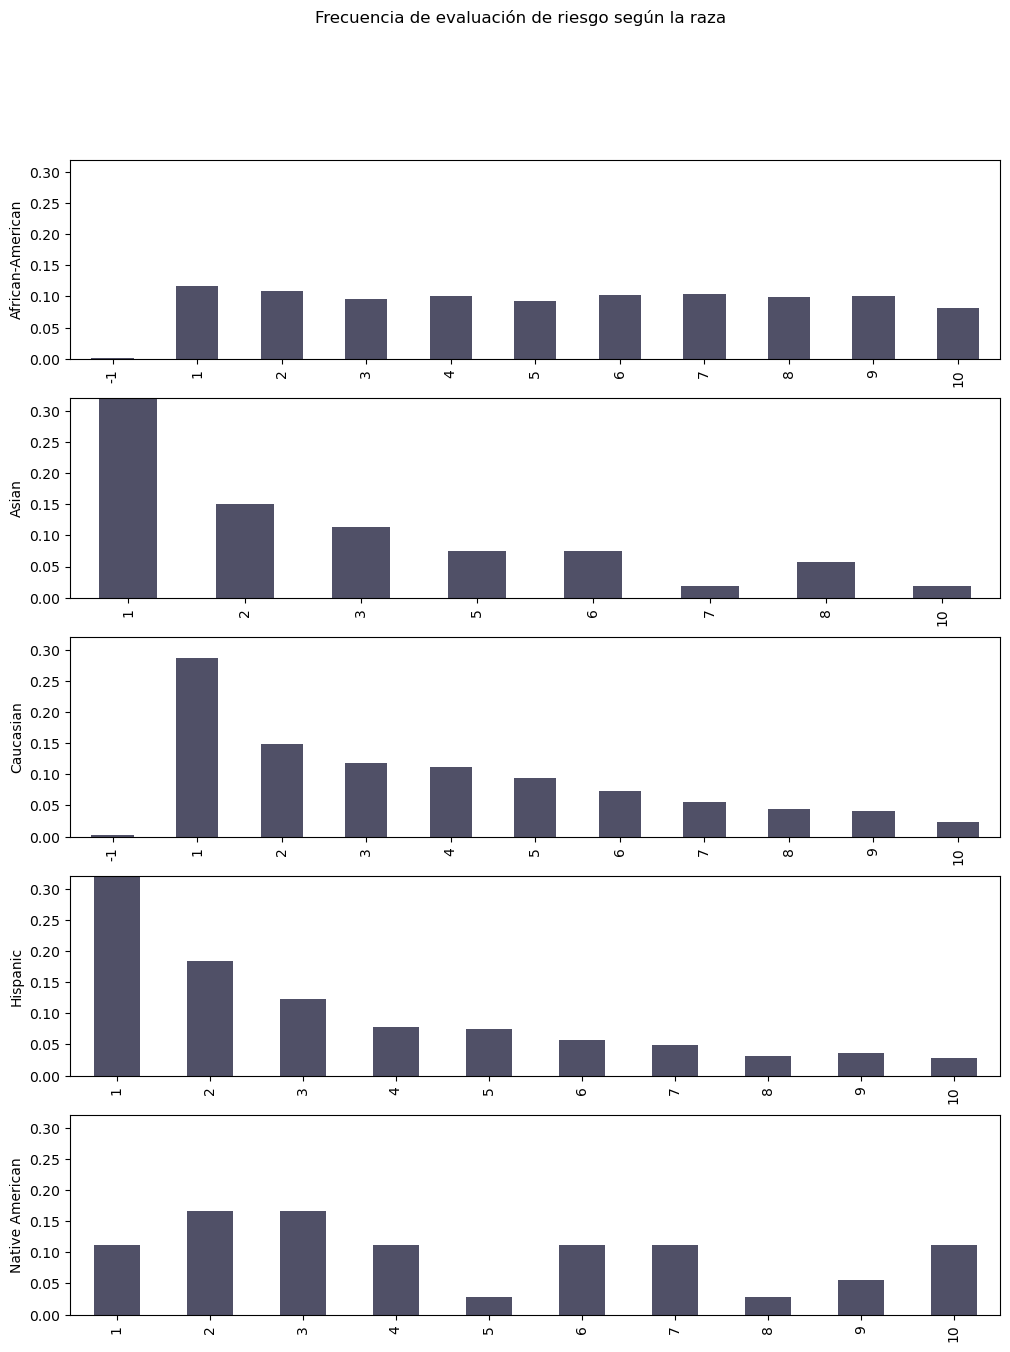

In [251]:
race_group = compas_score.groupby("race")
race_count = compas_score.groupby("race")["name"].count()

fig, ax = plt.subplots(5, figsize=(12, 15))

for (i, race) in enumerate(["African-American", "Asian", "Caucasian", "Hispanic", "Native American"]):
    (
        (race_group
            .get_group(race)
            .groupby("decile_score")["name"].count() / race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#505067")
    )
    ax[i].set_ylabel(race)
    ax[i].set_xlabel("")
   
    ax[i].set_ylim(0, 0.32)

fig.suptitle("Frequency of risk assessment by race")
plt.show()

Note that the African American race has a uniformly distributed risk assessment. In contrast, for the other races, the majority of individuals are at the lower levels of risk.

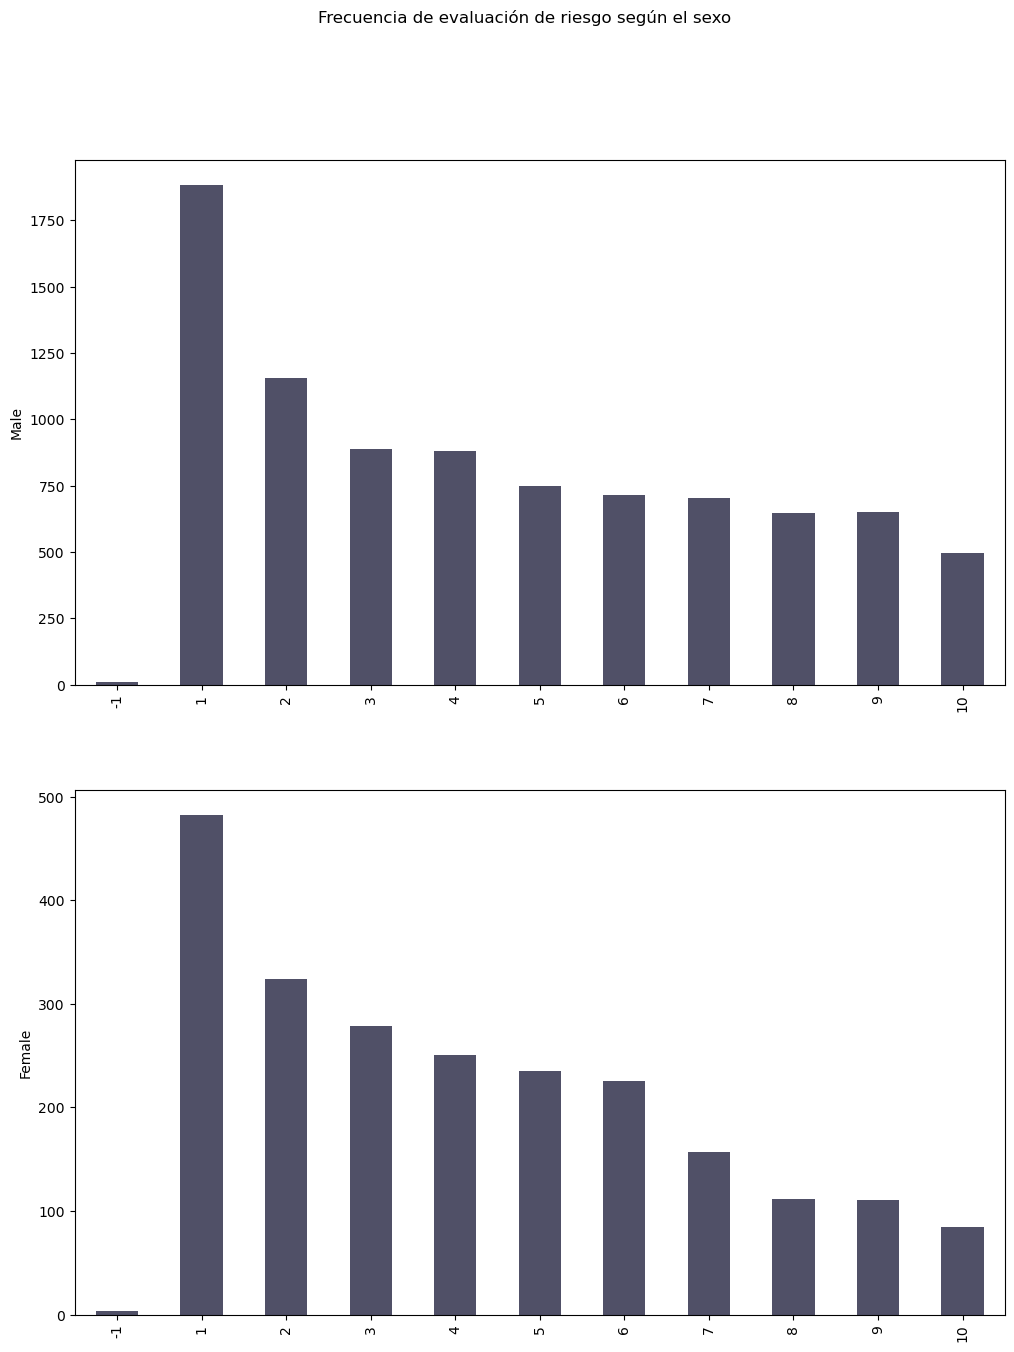

In [252]:
sex_group = compas_score.groupby("sex")
race_count = compas_score.groupby("sex")["name"].count()

fig, ax = plt.subplots(2, figsize=(12, 15))

for (i, sex) in enumerate(["Male", "Female"]):
    (
        (sex_group
            .get_group(sex)
            .groupby("decile_score")["name"].count() 
         #/ race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#505067")
    )
    ax[i].set_ylabel(sex)
    ax[i].set_xlabel("")
   
 #   ax[i].set_ylim(0, 0.)

fig.suptitle("Frequency of risk assessment by gender")
plt.show()

In this case, we observe a tendency for fewer women to be in the high-risk levels.

We repeat the same process for the risk assessment in violent offenses.

In [253]:
fitted_v_decile_score = ols('v_decile_score ~ age + C(sex) + C(race) + C(is_recid) + C(is_violent_recid)', data=compas_score).fit() 
print(fitted_v_decile_score.summary())

                            OLS Regression Results                            
Dep. Variable:         v_decile_score   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     795.4
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:24:15   Log-Likelihood:                -23035.
No. Observations:               11038   AIC:                         4.609e+04
Df Residuals:                   11028   BIC:                         4.616e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

We make a prediction of the v_decile_score value based on the previously mentioned data. We generate the contingency table, comparing the cases where a value greater than or equal to 7 is predicted with those where the actual value is greater than or equal to 7.

In [256]:
v_predicted = fitted_v_decile_score.predict(compas_score)
tabla = pd.crosstab(v_predicted >= 7, compas_score['v_decile_score'] >= 7, rownames=['Prediction'], colnames=['Real'])
tabla

Real,False,True
Prediction,,
False,9330,1708


In [258]:
from sklearn.metrics import classification_report
print(classification_report(compas_score['v_decile_score'] >= 7, v_predicted >= 7))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92      9330
        True       0.00      0.00      0.00      1708

    accuracy                           0.85     11038
   macro avg       0.42      0.50      0.46     11038
weighted avg       0.71      0.85      0.77     11038



/Users/danielperez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielperez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielperez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see that the accuracy is 85%, indicating that the system has a higher predictive capability for risk assessments in violent offenses.